# Assignment 7: Dimensionality Reduction

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking **'Runtime' > 'Restart session and run all'**.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

# Dataset

In this assignment, you will work on a text dataset. The Yelp reviews dataset consists of reviews from Yelp. It is extracted from the Yelp Dataset Challenge 2015 data. For more information, please refer to http://www.yelp.com/dataset_challenge. The Yelp reviews polarity dataset is a subset of Yelp reviews dataset and is constructed by considering stars 1 and 2 negative, and 3 and 4 positive.

In [1]:
# imports
import os
import numpy as np
import pandas as pd
import polars as pl
from scipy.sparse import csr_matrix
import sklearn.feature_extraction.text as sktext
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
import re
from sklearn.manifold import TSNE

import umap

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\Andy Yuan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Part 1: Data Preprocessing

## Question 1.1: Load data

Read the **`yelp.csv`** file as a **`polars.DataFrame`** and show the first 5 rows of the dataframe and its descriptive statistics.

In [2]:
# YOUR CODE HERE
yelp = pl.read_csv("yelp.csv")

# Display the first few rows
print(yelp.head(5))

# Descriptive statistics
yelp.describe()

shape: (5, 2)
┌───────────┬─────────────────────────────────┐
│ Sentiment ┆ Review                          │
│ ---       ┆ ---                             │
│ i64       ┆ str                             │
╞═══════════╪═════════════════════════════════╡
│ 0         ┆ Maintenance here is ridiculous… │
│ 1         ┆ I really enjoy smaller more in… │
│ 1         ┆ Looking at their menu, I was a… │
│ 1         ┆ Best sandwiches in Las Vegas! … │
│ 0         ┆ Was upset because they didnt h… │
└───────────┴─────────────────────────────────┘


statistic,Sentiment,Review
str,f64,str
"""count""",1500.0,"""1500"""
"""null_count""",0.0,"""0"""
"""mean""",0.494,null
"""std""",0.500131,null
"""min""",0.0,"""$24 for a burger and beer. \n…"
"""25%""",0.0,null
"""50%""",0.0,null
"""75%""",1.0,null
"""max""",1.0,"""wow, where do I begin? It too…"


## Question 1.2: Convert categorical variable

Since we are not predicting the categorical variable in this assignment, let's convert **`Sentiment`** to string:
- Replace **1** with **`positive`**.
- Replace **0** with **`negative`**.

Display the first 5 rows of the resulting dataframe.


In [3]:
# YOUR CODE HERE
yelp = yelp.with_columns(
    pl.col("Sentiment")
    .map_elements(lambda x: "positive" if x == 1 else "negative", return_dtype=pl.String)
)
print(yelp.head(5))

shape: (5, 2)
┌───────────┬─────────────────────────────────┐
│ Sentiment ┆ Review                          │
│ ---       ┆ ---                             │
│ str       ┆ str                             │
╞═══════════╪═════════════════════════════════╡
│ negative  ┆ Maintenance here is ridiculous… │
│ positive  ┆ I really enjoy smaller more in… │
│ positive  ┆ Looking at their menu, I was a… │
│ positive  ┆ Best sandwiches in Las Vegas! … │
│ negative  ┆ Was upset because they didnt h… │
└───────────┴─────────────────────────────────┘


## Question 1.3: Transform text

Apply **`Term Frequency - Inverse Document Frequency`** transformation using [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html):
- Eliminate accents and other characters
- Eliminate stopwords
- Eliminate words that appear in less than 5% and words that appear in more than 95% of texts
- Apply sublinear tf scaling

Extract and save the word list. Report the number of words that are kept.

In [4]:
# YOUR CODE HERE
TfIDFTransformer = sktext.TfidfVectorizer(strip_accents='unicode', # Eliminate accents and special characters
                      stop_words='english', # Eliminates stop words.
                      min_df = 0.01, # Eliminate words that do not appear in more than 5% of texts
                      max_df = 0.95, # Eliminate words that appear in more than 95% of texts
                      sublinear_tf=True # Use sublinear weights (softplus)
                      )
TfIDFyelp = TfIDFTransformer.fit_transform(yelp["Review"])
word_index = TfIDFTransformer.get_feature_names_out()
len(word_index)

970

## Question 1.4: Explore words

Based on TF-IDF scores, show the 10 most often repeated words and the 10 least often repeated words.

Hint: You might need to use [`np.argsort`](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html). Pay attention to sorting order.

In [5]:
# YOUR CODE HERE
sumtfidf = TfIDFyelp.sum(axis=0).A1
sorted_words_descending = np.argsort(sumtfidf)[::-1]
print(f"Top 10 words: {word_index[sorted_words_descending][:10]}")
sorted_words_ascending = np.argsort(sumtfidf)
print(f"Bottom 10 words: {word_index[sorted_words_ascending][:10]}")

Top 10 words: ['food' 'place' 'great' 'good' 'service' 'like' 'just' 'time' 'really'
 'don']
Bottom 10 words: ['break' 'mentioned' 'ignored' 'upset' 'nfirst' 'informed' 'arrive'
 'explained' 'request' 'admit']


# Part 2: Dimensionality Reduction

## Question 2.1: PCA

(1) Apply **normal PCA**. Set the number of components to 100. Report the percentage variance explained by the 100 PCs.

(2) Show the words that have positive weight in the **third PC** (index 2).

In [6]:
# (1) YOUR CODE HERE
nPCA = PCA(n_components=100)
nPCA.fit(np.asarray(TfIDFyelp.todense()))
total_variance = np.sum(nPCA.explained_variance_) * 100
print('The total explained variance of the first %i components is %.3f percent' % (nPCA.n_components_, total_variance))

The total explained variance of the first 100 components is 33.455 percent


In [7]:
# (2) YOUR CODE HERE
word_index[nPCA.components_[2,:]>0]

array(['10', '11', '12', '15', '20', '25', '30', '40', '45', '50', 'able',
       'admit', 'ago', 'ambiance', 'anymore', 'apparently', 'appetizer',
       'appetizers', 'appointment', 'arrive', 'arrived', 'ask', 'asked',
       'asking', 'atmosphere', 'attention', 'attentive', 'attitude',
       'authentic', 'away', 'awful', 'bad', 'bar', 'barely', 'bartender',
       'basic', 'basically', 'bathroom', 'beer', 'beers', 'believe',
       'birthday', 'bit', 'bother', 'bottle', 'brought', 'brunch',
       'bucks', 'burrito', 'business', 'busy', 'cafe', 'called', 'came',
       'card', 'care', 'case', 'cashier', 'cause', 'chain', 'chance',
       'changed', 'charge', 'charged', 'charlotte', 'check', 'checked',
       'chef', 'chicken', 'clearly', 'cold', 'combo', 'come', 'comes',
       'company', 'complain', 'completely', 'contact', 'conversation',
       'cook', 'cooked', 'cool', 'correct', 'couldn', 'counter', 'couple',
       'coupon', 'crab', 'crazy', 'credit', 'customer', 'customers',

## Question 2.2: LSA

(1) Apply **LSA** using [`TruncatedSVD`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html). Set:
- number of components to 100
- number of iterations to 10
- random state to 2025.

Report the percentage variance explained by the 100 PCs.

(2) Show the five words that relate the most with the **fifth PC** (index 4). What would you name this principal component?

In [8]:
# (1) YOUR CODE HERE
svd = TruncatedSVD(n_components=100, # How many concepts to extract
                   n_iter=10, # How many iterations to run
                   random_state=2025 # Random state. As SVD is rotation-invariant, we need to set this
                  )
svd.fit(TfIDFyelp)
print(f"The percentage variance explained by the 100 PCs is {svd.explained_variance_ratio_.sum() * 100} percent")

The percentage variance explained by the 100 PCs is 35.60010097143828 percent


In [9]:
# (2) YOUR CODE HERE
indices = np.argpartition(svd.components_[4, :], -5)[-5:]
indices
[word_index[j] for j in indices]

['cheese', 'salad', 've', 'great', 'pizza']

**Written answer:** This principal component can be related to positive places

## Question 2.3: PCA vs LSA

Compare PCA and LSA. Comment on your findings.

**Written answer:** The LSA model could do slightly better at explaining variance using the PCs. 

## Question 2.4: t-SNE

Apply **t-SNE**. Set:
- number of components to 2
- random first inintialization
- try a perplexity of 2 and 10.
- tightness of natural clusters to 30
- auto learning rate
- maximum number of iterations to 1000
- maximum number of iterations without progress before we abort to 100
- use cosine metric
- gradient threshold to 0.0000001
- random state to 2025

Create a plot, showing 2D projection of our data using t-SNE for both perplexities, in separate plots. Remember to add labels and title.

Written answer: Compare the two projections. Which projection would you think separates the classes better? Why?

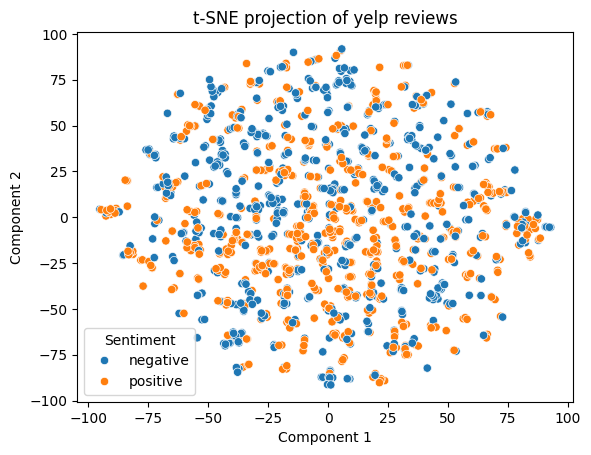

In [10]:
# YOUR CODE HERE - Perplexity 2
tSNEmapper = TSNE(n_components=2,               # How many dimensions to use. Never more than 2 or 3
                  init='random',                # First initialization. Sparse matrices need 'random'.  Otherwise use 'pca'
                  perplexity=2,    
                  early_exaggeration=30.0,      # How tight are the initial clusters.
                  learning_rate='auto',         # Related to above. Leave to auto
                  max_iter=1000,                  # Very important to let iterate enough
                  n_iter_without_progress=100,  # Set early stopping
                  metric='cosine',           # Metric to use to calculate distances.
                  min_grad_norm=1e-7,           # Minimum gradient to continue iterating
                  verbose=0,                    # Verbosity
                  random_state=2025,              # Random seed
                  n_jobs=-1,                     # Parallel processes
                 )
TSNE_embedding1 = tSNEmapper.fit_transform(TfIDFyelp)
sns.scatterplot(x=TSNE_embedding1[:, 0], y=TSNE_embedding1[:, 1], hue=yelp['Sentiment'])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("t-SNE projection of yelp reviews")
plt.show()

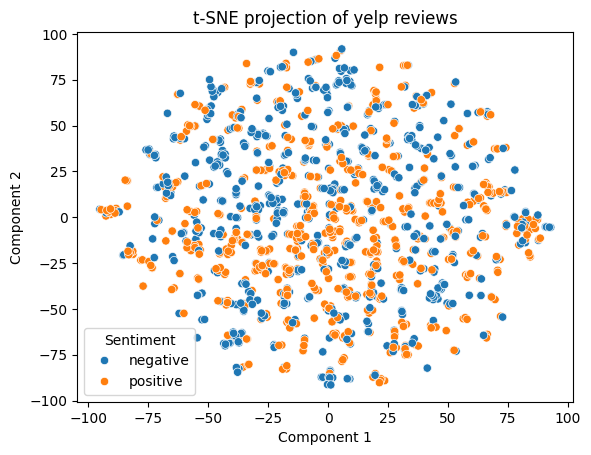

In [11]:
# YOUR CODE HERE - Perplexity 10
tSNEmapper10 = TSNE(n_components=2,               # How many dimensions to use. Never more than 2 or 3
                  init='random',                # First initialization. Sparse matrices need 'random'.  Otherwise use 'pca'
                  perplexity=2,    
                  early_exaggeration=30.0,      # How tight are the initial clusters.
                  learning_rate='auto',         # Related to above. Leave to auto
                  max_iter=1000,                  # Very important to let iterate enough
                  n_iter_without_progress=100,  # Set early stopping
                  metric='cosine',           # Metric to use to calculate distances.
                  min_grad_norm=1e-7,           # Minimum gradient to continue iterating
                  verbose=0,                    # Verbosity
                  random_state=2025,              # Random seed
                  n_jobs=-1,                     # Parallel processes
                 )
TSNE_embedding2 = tSNEmapper10.fit_transform(TfIDFyelp)
sns.scatterplot(x=TSNE_embedding2[:, 0], y=TSNE_embedding2[:, 1], hue=yelp['Sentiment'])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("t-SNE projection of yelp reviews")
plt.show()

**Written Answer:** It doesn't appear that the perplexities change the separation of the classes too much, if at all. However, I would take the larger perplexity since there are too many small clusters when I would rather have two large ones.

## Question 2.5: UMAP

(1) Apply **UMAP**. Set:
- number of components to 2
- use 10 nearest neighbors
- use cosine metric
- number of training epochs to 1000
- effective minimum distance between embedded points to 0.1
- effective scale of embedded points to 1
- avoids excessive memory use
- do not use a random seed to allow parallel processing.

(2) Create a plot, showing 2D projection of our data using UMAP. Remember to add labels and title.

In [12]:
# (1) YOUR CODE HERE
reducer = umap.UMAP(n_neighbors=10,              # Number of neareast neighbours to use.
                    n_components=2,              # Number of components. UMAP is robust to larger values
                    metric='cosine',             # Metric to use.
                    n_epochs=1000,               # Iterations. Set to convergence. None implies either 200 or 500.
                    min_dist=0.1,                # Minimum distance embedded points. Smaller makes clumps, larger, sparseness.
                    spread=1.0,                  # Scale to combine with min_dist
                    low_memory=False,             # Run slower, but with less memory.
                    n_jobs=-1,                   # Cores to use
                    verbose=0                 # Verbosity
                   )
UMAP_embedding = reducer.fit_transform(TfIDFyelp)

C:\Users\Andy Yuan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


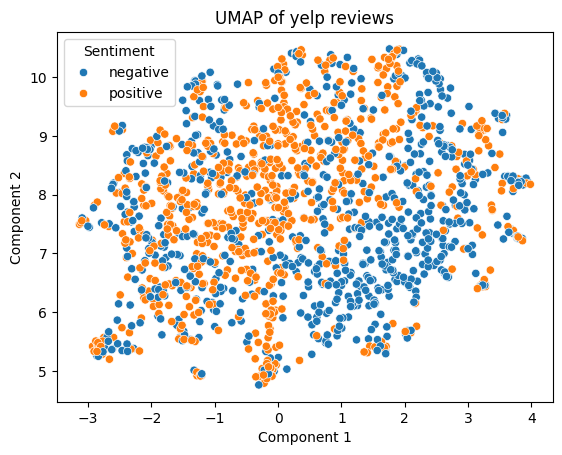

In [13]:
# (2) YOUR CODE HERE
sns.scatterplot(x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=yelp['Sentiment'])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("UMAP of yelp reviews")
plt.show()

## Question 2.6: t-SNE vs UMAP

Compare t-SNE (perplexity 10) and UMAP. Comment on your findings.

**Written answer:** The UMAP projection separates the classes much better, where although there is significant overlap, there is a clear pattern as to where positives tend to be around negatives. In contrast, the t-SNE plot did not have any.